# Assignment 3 : "Word Vectors and Classification"
Due: Monday 2pm, Feburary 1, 2021, via Moodle

### Submission guidelines

- Solutions need to be uploaded as a single Jupyter notebook. You will find many provided codes in the notebook, your task is to fill in the missing cells.
- For the written solution, use LaTeX in markdown inside the same notebook. Do *not* hand in a separate file for it.
- Download the .zip file containing the dataset but do *not* upload it with your solution.
- It is sufficient if one person per group uploads the solution to Moodle, but make sure that the names of
all team members are given in the notebook.

--------

## Task 1: F.R.I.E.N.D.S and  Word2Vec ( 3+ 2+ 3 = 8 points) 

Friends is an American television sitcom, created by David Crane and Marta Kauffman. In this assignment we will use the transcripts from the show to train a Word2Vec model using the Gensim library.

### Subtask 1: Pre-processing 
We start by loading and cleaning the data. Download the dataset for this assignment and load the `friends_quotes.csv` using pandas. The dataset is from Kaggle (https://www.kaggle.com/ryanstonebraker/friends-transcript) and is created for building a classifier that could determine which friend from the Friend's TV Show would be most likely to say a quote. The column `quote` contains the line from the movie and `author` is the one who spoke it. Since these are the only two columns we need, we remove the rest and only keep these two. 

In [1]:
import re  
import pandas as pd  
from collections import defaultdict  
import spacy 
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [76]:
df = pd.read_csv('C:/Users/Mazz Issa/Documents/Kurse/TA/Ex03/ITA_assignment3_data/friends_quotes.csv')### Load the data #### 
### filter out columns ### 
df= df[['author','quote']]
df.head()

,author,quote
0,Monica,There's nothing to tell! He's just some guy I ...
1,Joey,"C'mon, you're going out with the guy! There's ..."
2,Chandler,"All right Joey, be nice. So does he have a hum..."
3,Phoebe,"Wait, does he eat chalk?"
4,Phoebe,"Just, 'cause, I don't want her to go through w..."


Fortunately, there is no missing data, so we do not need to worry about that. 

In [77]:
df.isnull().sum() # check for missing data

author    0
quote     0
dtype: int64

use SpaCy similar to assignment 2 to pre-process the text, perform the following steps: 
- lowercase the words 
- remove the stopwords and single characters
- use regex to remove non-alphabetic characters (anything that is not a number or alphabet including punctuations), in other words only keep "a" to "z" and digits. 
- remove lines that have less than 3 words, since they cannot contribute much to the training process.

Please do not add additional steps on your own or additional cleaning, we want to create comparable results. 

In [78]:
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser","ner"])
stopwords = spacy.lang.en.stop_words.STOP_WORDS # only use these stop words, do not add your own! 
df["quote"] = df["quote"].str.lower().str.replace(r'[^\w\s]+',"").str.split()# lowercase and remove non-alphabetic characters
quotes =df["quote"].tolist() # to save all the lines 

### Your Code ### 
quotes = [[word for word in sen  if not word in stopwords]for sen in quotes] ## remove stop words
quotes = [sen for sen in quotes if not len(sen) <= 3]  ## remove sentences shorter than 3 word

The next step is to build the vocabulary of the words and word combinations we want to learn representations from. We choose a subset of the most frequent words and bigrams to represent our corpus.
- use the Gensim Phrases package to automatically detect common phrases (bigrams) from a list of lines from the previous step (`min_count=10`). Now words like New_York will be considered as one entity and character names like joey_tribbiani will be recognized.
- create a list of words/bigrams with their frequencies and choose the top 15.000 words for the vocabulary, to keep the computation time-limited and choose the most important words.

In [2]:
from collections import Counter

In [80]:
from gensim.models.phrases import Phrases, Phraser
sent = [word for sen in quotes for word in sen]#list of all words# 
phrases = Phrases(quotes, min_count = 10)#define the phraser for bi-gram creation# 

#new_lines = phrases[sent] # 1D list von quotes und a  #transform the lines# 

new_lines = [phrases[sen] for sen in quotes]

### find the top words for the vocabulary### 
vocab= [ word for word , word_count in Counter(sent).most_common(15000)] ###top words ### 

INFO - 20:10:46: collecting all words and their counts
INFO - 20:10:46: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 20:10:46: PROGRESS: at sentence #10000, processed 85787 words and 64581 word types
INFO - 20:10:47: PROGRESS: at sentence #20000, processed 172037 words and 113909 word types
INFO - 20:10:47: PROGRESS: at sentence #30000, processed 258076 words and 159674 word types
INFO - 20:10:47: collected 166311 word types from a corpus of 271703 words (unigram + bigrams) and 31658 sentences
INFO - 20:10:47: using 166311 counts as vocab in Phrases<0 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000>


### Subtask 2: Training The Model


Use Gensim the implementation of Word2Vec to train a model on the scripts. The training can be divided into 3 stages:


1) Set up your model with parameters, define your parameters in such a way that the following conditions are satisfied:
 - ignores all words that have a total absolute frequency less than 2.
 - dimensions of the embeddings: 100 
 - initial learning rate of 0.03 
 - 20 negative samples 
 - window size 3 
 - learning rate in the training will decrease as you apply more and more updates. Most of the time when starting with gradient descent the initial steps can be larger, and as we get close to the local minima it is best to use smaller steps to avoid jumping over the local minima. This adjustment is done internally using a learning rate scheduler. Make sure that the smallest learning rate does not go below 0.0001.
 - set the threshold for configuring which higher-frequency words are randomly down-sampled to 6e-5. This parameter forces the sampling to choose the very frequent words less often in the sampling.
 - set the hashfunction of the word2vec to the given function.
 - train on a single worker to make sure you get the same result as ours.

In [3]:
from gensim.models import Word2Vec  
def hash(astring):
    return ord(astring[0])

In [82]:
w2v = Word2Vec(size =100, negative=20 ,alpha=0.03, window=3, min_count=2, min_alpha=0.0001, sample=6e-5  ,workers = 1) ### your code ### 

2) before training, Word2Vec requires us to build the vocabulary table by filtering out the unique words and doing some basic counts on them.
If you look at the logs you can see the effect of `min_count` and `sample` on the word corpus. Use the `build_vocab` function to process the data.

In [83]:
w2v.build_vocab(new_lines)### your code ### 

INFO - 20:10:57: collecting all words and their counts
INFO - 20:10:57: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 20:10:57: PROGRESS: at sentence #10000, processed 82883 words, keeping 9938 word types
INFO - 20:10:58: PROGRESS: at sentence #20000, processed 166277 words, keeping 13932 word types
INFO - 20:10:58: PROGRESS: at sentence #30000, processed 249427 words, keeping 17512 word types
INFO - 20:10:58: collected 17996 word types from a corpus of 262585 raw words and 31658 sentences
INFO - 20:10:58: Loading a fresh vocabulary
INFO - 20:10:58: effective_min_count=2 retains 9462 unique words (52% of original 17996, drops 8534)
INFO - 20:10:58: effective_min_count=2 leaves 254051 word corpus (96% of original 262585, drops 8534)
INFO - 20:10:58: deleting the raw counts dictionary of 17996 items
INFO - 20:10:58: sample=6e-05 downsamples 962 most-common words
INFO - 20:10:58: downsampling leaves estimated 119566 word corpus (47.1% of prior 254051)
INFO - 20:

3) Finally, we get to train the model. Train the model for 100 epochs. This will take a while. As we do not plan to train the model any further, we call `init_sims()`, which will make the model much more memory-efficient by precomputing L2-norms of word weight vectors for further analysis. 

In [84]:
w2v.train(new_lines, total_examples=w2v.corpus_count, epochs=100)

INFO - 20:11:08: training model with 1 workers on 9462 vocabulary and 100 features, using sg=0 hs=0 sample=6e-05 negative=20 window=3
INFO - 20:11:09: EPOCH 1 - PROGRESS: at 30.55% examples, 34088 words/s, in_qsize 2, out_qsize 0
INFO - 20:11:10: EPOCH 1 - PROGRESS: at 60.68% examples, 33285 words/s, in_qsize 2, out_qsize 0
INFO - 20:11:11: EPOCH 1 - PROGRESS: at 98.84% examples, 36521 words/s, in_qsize 1, out_qsize 0
INFO - 20:11:11: worker thread finished; awaiting finish of 0 more threads
INFO - 20:11:11: EPOCH - 1 : training on 262585 raw words (119618 effective words) took 3.3s, 36603 effective words/s
INFO - 20:11:12: EPOCH 2 - PROGRESS: at 53.06% examples, 62528 words/s, in_qsize 2, out_qsize 0
INFO - 20:11:13: worker thread finished; awaiting finish of 0 more threads
INFO - 20:11:13: EPOCH - 2 : training on 262585 raw words (119569 effective words) took 1.9s, 63036 effective words/s
INFO - 20:11:14: EPOCH 3 - PROGRESS: at 64.54% examples, 75291 words/s, in_qsize 2, out_qsize 0


INFO - 20:12:01: worker thread finished; awaiting finish of 0 more threads
INFO - 20:12:01: EPOCH - 24 : training on 262585 raw words (119565 effective words) took 2.4s, 48955 effective words/s
INFO - 20:12:02: EPOCH 25 - PROGRESS: at 49.45% examples, 57746 words/s, in_qsize 1, out_qsize 0
INFO - 20:12:03: EPOCH 25 - PROGRESS: at 94.97% examples, 54148 words/s, in_qsize 1, out_qsize 0
INFO - 20:12:03: worker thread finished; awaiting finish of 0 more threads
INFO - 20:12:03: EPOCH - 25 : training on 262585 raw words (119382 effective words) took 2.2s, 53610 effective words/s
INFO - 20:12:04: EPOCH 26 - PROGRESS: at 49.45% examples, 54598 words/s, in_qsize 1, out_qsize 0
INFO - 20:12:05: worker thread finished; awaiting finish of 0 more threads
INFO - 20:12:05: EPOCH - 26 : training on 262585 raw words (119639 effective words) took 1.8s, 66666 effective words/s
INFO - 20:12:06: EPOCH 27 - PROGRESS: at 72.03% examples, 86021 words/s, in_qsize 1, out_qsize 0
INFO - 20:12:06: worker thread

INFO - 20:12:48: EPOCH 50 - PROGRESS: at 38.14% examples, 44063 words/s, in_qsize 1, out_qsize 0
INFO - 20:12:49: EPOCH 50 - PROGRESS: at 75.95% examples, 43937 words/s, in_qsize 2, out_qsize 0
INFO - 20:12:50: worker thread finished; awaiting finish of 0 more threads
INFO - 20:12:50: EPOCH - 50 : training on 262585 raw words (119485 effective words) took 2.7s, 44370 effective words/s
INFO - 20:12:51: EPOCH 51 - PROGRESS: at 38.14% examples, 45324 words/s, in_qsize 2, out_qsize 0
INFO - 20:12:52: EPOCH 51 - PROGRESS: at 79.58% examples, 46293 words/s, in_qsize 1, out_qsize 0
INFO - 20:12:52: worker thread finished; awaiting finish of 0 more threads
INFO - 20:12:52: EPOCH - 51 : training on 262585 raw words (119600 effective words) took 2.6s, 46191 effective words/s
INFO - 20:12:53: EPOCH 52 - PROGRESS: at 38.14% examples, 44959 words/s, in_qsize 1, out_qsize 0
INFO - 20:12:54: EPOCH 52 - PROGRESS: at 94.97% examples, 55938 words/s, in_qsize 1, out_qsize 0
INFO - 20:12:54: worker thread

INFO - 20:13:42: EPOCH - 72 : training on 262585 raw words (119456 effective words) took 2.2s, 54251 effective words/s
INFO - 20:13:43: EPOCH 73 - PROGRESS: at 38.14% examples, 42998 words/s, in_qsize 1, out_qsize 0
INFO - 20:13:44: EPOCH 73 - PROGRESS: at 75.95% examples, 42467 words/s, in_qsize 1, out_qsize 0
INFO - 20:13:45: worker thread finished; awaiting finish of 0 more threads
INFO - 20:13:45: EPOCH - 73 : training on 262585 raw words (119287 effective words) took 2.6s, 45348 effective words/s
INFO - 20:13:46: EPOCH 74 - PROGRESS: at 49.45% examples, 57727 words/s, in_qsize 2, out_qsize 0
INFO - 20:13:47: EPOCH 74 - PROGRESS: at 91.03% examples, 51357 words/s, in_qsize 1, out_qsize 0
INFO - 20:13:47: worker thread finished; awaiting finish of 0 more threads
INFO - 20:13:47: EPOCH - 74 : training on 262585 raw words (119511 effective words) took 2.3s, 51279 effective words/s
INFO - 20:13:48: EPOCH 75 - PROGRESS: at 38.14% examples, 43587 words/s, in_qsize 2, out_qsize 0
INFO - 2

INFO - 20:14:36: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:36: EPOCH - 94 : training on 262585 raw words (119649 effective words) took 3.2s, 37857 effective words/s
INFO - 20:14:37: EPOCH 95 - PROGRESS: at 56.96% examples, 65400 words/s, in_qsize 2, out_qsize 0
INFO - 20:14:38: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:38: EPOCH - 95 : training on 262585 raw words (119608 effective words) took 1.7s, 71184 effective words/s
INFO - 20:14:39: EPOCH 96 - PROGRESS: at 75.95% examples, 87547 words/s, in_qsize 1, out_qsize 0
INFO - 20:14:39: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:39: EPOCH - 96 : training on 262585 raw words (119719 effective words) took 1.4s, 88449 effective words/s
INFO - 20:14:40: EPOCH 97 - PROGRESS: at 75.95% examples, 88116 words/s, in_qsize 1, out_qsize 0
INFO - 20:14:41: worker thread finished; awaiting finish of 0 more threads
INFO - 20:14:41: EPOCH - 97 : training on 262585 raw

(11958827, 26258500)

In [85]:
w2v.init_sims(replace=True)###your code ### 

INFO - 20:14:48: precomputing L2-norms of word weight vectors


### Subtask 3: Exploring the Model


As mentioned in the lecture, word embeddings are suited for similarity and analogy tasks. Let's explore some of that with our dataset: 

We look for most similar words to the famous coffee shop where most of the episodes took place, namely `central_perk` and also one of the characters `joey`. If you have followed the exercise correctly until now, you should see that words like `laying` are similar to `central_perk` and the other main characters are also considered similar to `joey`.



In [106]:
w2v.wv.similarity("central_perk" , "joey")

0.12335912

In [105]:
w2v.save###your code###
w2v.save("friends_w2v_model.model")
# model = Word2Vec.load("friends_w2v_model.model")

INFO - 20:42:38: saving Word2Vec object under friends_w2v_model.model, separately None
INFO - 20:42:38: not storing attribute vectors_norm
INFO - 20:42:38: not storing attribute cum_table
INFO - 20:42:38: saved friends_w2v_model.model


In [107]:
w2v.wv.similarity("laying" , "joey") ###your code### 

0.33376282

Look at the similarity of `mrs_green` to `rachel` (her mom) and `ross`  and `spaceship` (urelated). The first one should have a high and the second low score. Finally look at the similarity of `smelly_cat` ( a song from pheobe) and `song` the similarity should be high.

In [95]:
w2v.wv.similarity("mrs_green", "rachel")###your code### 

0.5045453

In [96]:
w2v.wv.similarity("ross", "spaceship") ###your code### 

-0.12668173

In [97]:
w2v.wv.similarity("smelly_cat", "song")###your code### 

0.53361744

In [104]:
a = (10, 'a')


'a'

We can also ask our model to give us the word that does not belong to a list of words. Let's see from the list of all 5 characters which one is the most dissimilar? 


In [98]:
character_names= ['joey', 'rachel', 'phoebe','monica','chandler']

In [168]:
### your code### 

## the way i understood the task is:
    ## among all five characters, which pair of characters are the most dissimilar

## function to compute similarity between chars and returns two lists
## a list containing pair of characters that are most similar to each other
## a list containing pair of characters that are most dissimilar to each other
def analogy(list):
    most_similar = []
    most_dissimilar = []
    for  i in range(len(list)): #
        sim_ = (-10,list[i],'')
        dis_sim_ = (10, list[i], '')
        for j in range(0,len(list)):
            if(j == i): 
                continue
            else:
                sim = w2v.wv.similarity(list[i],list[j])
                if sim_[0] < sim:
                    sim_ = ( sim , list[i],list[j]) 
                if dis_sim_[0] > sim:
                    dis_sim_ = ( sim , list[i],list[j]) 

        most_similar.append(sim_), most_dissimilar.append(dis_sim_)
    return most_similar, most_dissimilar

sim, dis = analogy(character_names)
print("dissimilar pair of characters:")
for pair in dis:
    print(pair, "\n")

dissimilar pair of characters:
(0.61173326, 'joey', 'phoebe') 

(0.6389175, 'rachel', 'joey') 

(0.61173326, 'phoebe', 'joey') 

(0.6711618, 'monica', 'joey') 

(0.67341334, 'chandler', 'rachel') 



Based on the analogies, which word is to `rachel` as `man` is to `women`? (print the top 3); you should get `chandler` and `monica` among the answers.

In [221]:
 ### your code### 
def analogy(x1, x2, x3, y1):
    result = w2v.wv.most_similar(positive=[x1, x2,x3], negative=[y1],topn=3)
    return result
analogy = analogy('man','woman','rachel', 'act' )
print(analogy)

### for some reason i got at first  the word "look on the second place " then monica and chandler on 3rd and 4rth
## so i decided to add a negative word that represents a verb to the most fit to that was 'act' 

[('monica', 0.5237314701080322), ('chandler', 0.5017028450965881), ('ross', 0.4923253655433655)]


In [412]:
embs = np.empty((0, 100), dtype='f')# to save all the embeddings
embs = np.append(embs,[w2v.wv['joey']], axis=0) # adds the vector of the query word


#close_words = w2v.wv.most_similar(positive=['joey'], topn=10) # gets list of most similar words
#for i in close_words[:1]:
#    print(w2v.wv[i[0]])
#    print(i[0])

Finally, lets use t-SNE to look at the distribution of our embeddings in the vector space for the character `joey`. Follow the instructions and fill in the blank in the `tsneplot` function.

In [217]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
from sklearn.manifold import TSNE

In [415]:
def tsneplot(model, word):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction for the top 10 most similar and dissimilar words
    """
    embs = np.empty((0, 100), dtype='f')# to save all the embeddings
    word_labels = [word]
    color_list  = ['green']
   
    embs = np.append(embs,[w2v.wv[word]], axis=0) # adds the vector of the query word

    close_words = model.wv.most_similar(positive=[word], topn=10) # gets list of most similar words
    far_words = model.wv.most_similar(negative=[word], topn=10) # gets list of most dissimilar words
                                #  (get the sorted list of all the words and their similarity and choose the bottom 10 )
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = w2v.wv[wrd_score[0]]#get the vector 
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        embs = np.append(embs, [wrd_vector], axis=0)
        
    # adds the vector for each of the furthest words to the array
    for wrd_score in far_words:
        wrd_vector = w2v.wv[wrd_score[0]]#get the vector 
        word_labels.append(wrd_score[0])
        color_list.append('red')
        embs = np.append(embs, [wrd_vector], axis=0)
    np.set_printoptions(suppress=True)
    print(embs.shape)
    Y = TSNE(n_components=2, random_state=42, perplexity=15).fit_transform(embs)# with  n_components=2, random_state=42, perplexity=15 
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(10, 10)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

(21, 100)


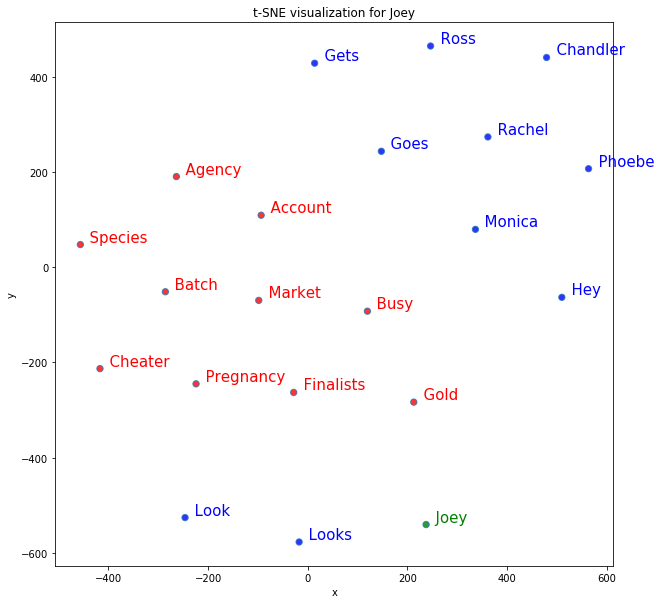

In [416]:
tsneplot(w2v, 'joey')

## Task 2: Multi-class Classification ( 1+ 3 + 2 = 6 points)
In this task, we aim to classify consumer finance complaints into 12 pre-defined classes. Note that this is not a multi-label task, and we assume that each new complaint is assigned to one and only one category. The data comes from https://www.data.gov/ (US government’s open data) and contains complaints that are published after the company responds, confirming a commercial relationship with the consumer, or after 15 days, whatever comes first.


### Sub Task 1: Data Exploration

Read the data to a pandas dataframe from `complaints.csv`; this is a rather large file of 206MB. Keep only the `Consumer complaint narrative` (input text) and `product`(labels). Remove the missing values, rename `Consumer complaint narrative` to `Narrative` for ease of use, and add a column encoding the product as an integer. This will represent your labels for classification and the mapping will be used later on. Create two dictionaries: one mapping the ids to products and one mapping products to their ids.

In [4]:
import pandas as pd
from io import StringIO
df = pd.read_csv("C:/Users/Mazz Issa/Documents/Kurse/TA/Ex03/ITA_assignment3_data/complaints.csv")###read the file ####
df = df[["Product", "Consumer complaint narrative"]] ###keep the columns you need ####
df = df.rename(columns={"Consumer complaint narrative" : "Narrative"}) ###rename columns ####
df.head()

,Product,Narrative
0,Checking or savings account,NaN
1,"Money transfer, virtual currency, or money ser...","I was sold access to an event digitally, of wh..."
2,Vehicle loan or lease,NaN
3,Checking or savings account,NaN
4,Checking or savings account,NaN


In [249]:
df= df.dropna() ### remove missing #### 
df['product_id'] = df.groupby("Product").ngroup() ### integer ids for product ### 
df = df[["product_id", "Product", "Narrative"]] ## rearrange the columns order
### create the dictionary ####
product_to_id = pd.Series(df.product_id.values, index=df.Product).to_dict()
product_to_id = dict(sorted(product_to_id.items(), key=lambda item: item[1]))
id_to_product = pd.Series(df.Product.values, index=df.product_id).to_dict()
id_to_product = dict(sorted(id_to_product.items(), key=lambda item: item[1]))

df.head()

,product_id,Product,Narrative
1,5,"Money transfer, virtual currency, or money ser...","I was sold access to an event digitally, of wh..."
5,12,Vehicle loan or lease,I LEASED MY CAR ON XX/XX/XXXX AND MADE PAYMENT...
6,11,Student loan,My original lender was XXXX XXXX XXXX ; this l...
8,11,Student loan,I was misled by XXXX XXXX and my degree did n...
10,12,Vehicle loan or lease,I purchased a vehicle 3 years ago. As of recen...


In [159]:
id_to_product

{0: 'Bank account or service',
 1: 'Checking or savings account',
 2: 'Consumer Loan',
 3: 'Credit card',
 4: 'Credit reporting',
 5: 'Money transfer, virtual currency, or money service',
 6: 'Money transfers',
 7: 'Other financial service',
 8: 'Payday loan',
 9: 'Payday loan, title loan, or personal loan',
 10: 'Prepaid card',
 11: 'Student loan',
 12: 'Vehicle loan or lease',
 13: 'Virtual currency'}

Look at the class distribution of the products. It is always a good idea to look at the relative number of instances for each class before performing any classification task. Use the `plot` function from the dataframe to show the number of instances in each class in a histogram.

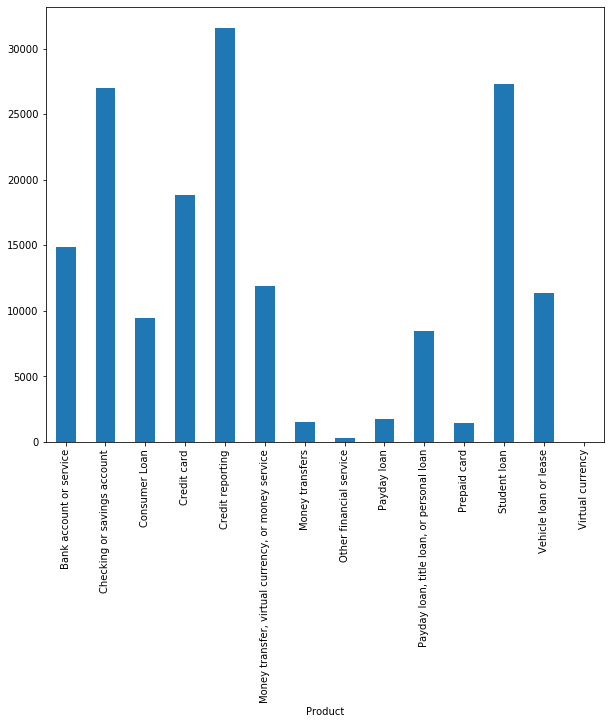

In [62]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
df.groupby("Product").Narrative.count().plot.bar(ylim=0) ### your code ###
plt.show()

If you have done the exercise correctly you should observe a class imbalance with `credit reporting` having the most complaints. This can result in some difficulties for standard algorithms, making them biased towards the majority class and treating the minority classes as outliers and unimportant. One way to overcome this problem is by using **undersampling** or **oversampling**. However, this is beyond the scope of this assignment.

### Sub Task 2: Text Representation and Training the Classifier 
Before performing any classification we need to split our data into train and test sets. Use `sklearn` to save 20 percent of the data for the test and the rest for training. Make sure to input the index of the data frame to retrieve the indices of the test and train. 


In [85]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, indices_train, indices_test = \
                    train_test_split(df["Narrative"],df["Product"],df.index, test_size=0.2, random_state=1)### your code ###

To perform any sort of classification task, we first need to convert our raw text into some vector representation. Let's use the `TfidfVectorizer` from `sklearn` to convert the `narrative` column into TF-IDF vectors. When transforming the text keep the following in mind:
- use the logarithmic form for frequency
- remove accents (ASCII) 
- lowercase all characters 
- remove `English` stop words 
- ignore terms that have a document frequency strictly less than 10
- smooth IDF weights by adding one to document frequencies 
- output row should have unit L2 norm
- set the encoding to `Latin-1`
- extract both uni-grams and bi-grams 
- build a vocabulary that only considers the top 10.000 features
Keep in mind that the vectorizer should be trained **only** on the training data, and the test data should be transformed using the same model.

In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(encoding = 'Latin-1', strip_accents='ascii', lowercase=True,stop_words='english',ngram_range=(1,2),
                        min_df=10, max_features=10000, smooth_idf = True, norm='l2'  ) ###initlize the model ### 

X_train = tfidf.fit_transform(X_train) ###transform text  ### 
X_train.shape # should be (132647, 10000) 

(132647, 10000)

After the data transformation, we attain the features and labels, to train the classifier. In our case, we use **Naive Bayes Classifier**. 
- split the features and labels into training and test set (set the random state to 42) 
- use `MultinomialNB` from sklearn to classify the data 

In [109]:
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test, indices_train, indices_test = \
                    train_test_split(df["Narrative"],df["Product"],df.index, test_size=0.2, random_state=42)### your code ###
tfidf.fit(X_train)
X_train, X_test = tfidf.transform(X_train), tfidf.transform(X_test)

clf = MultinomialNB()
clf.fit(X_train, y_train)

prediction = clf.predict(X_test)

In [126]:
def error_rate_cal(x,y):
    if(len(x) != len(y)):
        return "Error: inputs length does not match!"
    length = len(x)
    count = 0
    for i, j in zip(x, y):
        if i != j:
            count += 1
    return (count/length)*100

In [127]:
error_rate = error_rate_cal(prediction, y_test)
error_rate

26.400699595923044

### Sub Task 3: Model Evaluation  

We evaluate our model using the held-out test data. We are going to look at the confusion matrix to show the performance of the model. 

In [216]:
def get_from_dict(labels): ### a helper function to get values from dict
    value_list =[]
    for i in labels:
        value_list.append(product_to_id.get(i))
    return value_list

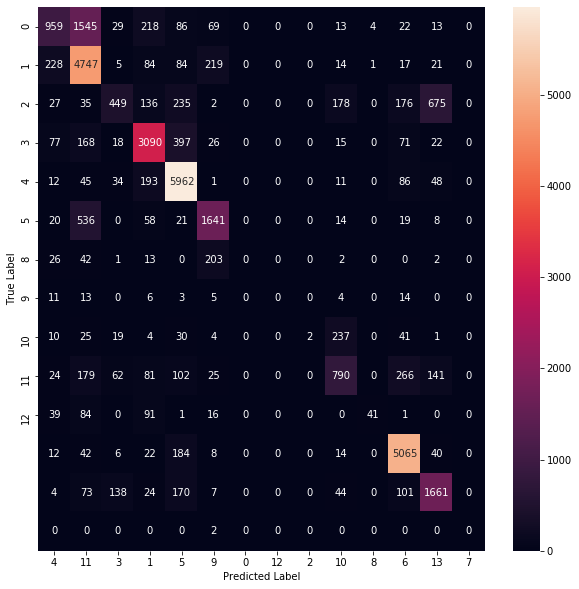

In [191]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = prediction ### predict on the test set ### 
labels = df['Product'].unique() ## labels


conf = confusion_matrix(y_test, y_pred)### create the confusion matrix ### 
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf, annot=True, fmt='d',
            xticklabels= get_from_dict(y_test.unique()),  ###products names from the dictionary ###,
            yticklabels= get_from_dict(np.unique(y_pred)) )### products names from the dictionary###)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

<font color='green'> it seem like out prediction did not assign any data to some labels  ( 0,7,12)</font>\
<font color='green'> i ploted another graph below to show that </font>

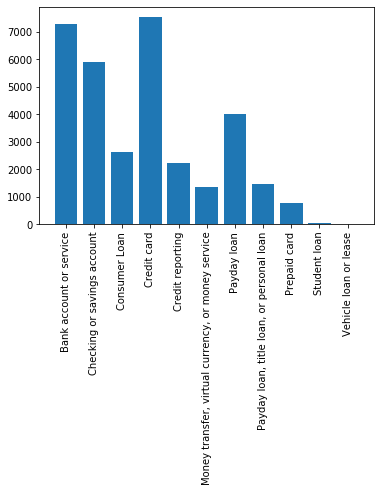

In [218]:
unique_pred = np.unique(y_pred)
pred_counter = Counter(y_pred)
plt.bar(unique_pred, pred_counter.values())
plt.xticks(unique_pred, rotation=90)
plt.show()

The majority of the predictions end up on the diagonal (predicted label = actual label). The diagonal shows the correct classified classes. However, there are several misclassifications, specifically `Checking or savings account` is often confused with `Bank account or service`. Let's take a look at why this happens. For this, we look at 5 misclassified examples.

In [278]:
fofo = df[df['Product'] == actual]
fofo ## df.shape = 14885
fofo[fofo.index.isin(dd)] ## shape

,product_id,Product,Narrative
57572,0,Bank account or service,I 'm currently on XXXX somy funds are limited....
69521,0,Bank account or service,I put in several request for Documents used in...
83651,0,Bank account or service,"On XXXX XXXX, Wells Fargo allowed this unautho..."
83661,0,Bank account or service,"On XXXX XXXX, XXXX I have contacted Bank of Am..."
83780,0,Bank account or service,Over a year ago I closed acct for XXXX with Ne...
...,...,...,...
552999,0,Bank account or service,I 've been a customer of TD Bank NA ( formally...
553370,0,Bank account or service,"Good Morning, I was not sure you handled these..."
558324,0,Bank account or service,"on XXXX, i used my Direct Express Debit card (..."
559326,0,Bank account or service,I recently moved back to XXXX to start a new j...


In [285]:
actual='Bank account or service'
predicted= 'Checking or savings account'
### print only the top 10 
#df ###choose the ones that have an actual label of Bank account or service and the predicted label of Checking or savings account ###)
misclassified = df[(df['Product'] == actual) | (df['Product'] == predicted)] ## from df get all rwo where labels== actual and predicted 
misclassified ## df.shape = 41901 

indices_of_predicted = indices_test[y_pred == predicted] ## list of indices where y_pred == predicted

misclassified = misclassified[misclassified.index.isin(indices_of_predicted)] ## shape 6292
misclassified[misclassified['product_id'] == 0] ## shape 1454

,product_id,Product,Narrative
57572,0,Bank account or service,I 'm currently on XXXX somy funds are limited....
69521,0,Bank account or service,I put in several request for Documents used in...
83651,0,Bank account or service,"On XXXX XXXX, Wells Fargo allowed this unautho..."
83661,0,Bank account or service,"On XXXX XXXX, XXXX I have contacted Bank of Am..."
83780,0,Bank account or service,Over a year ago I closed acct for XXXX with Ne...
...,...,...,...
552999,0,Bank account or service,I 've been a customer of TD Bank NA ( formally...
553370,0,Bank account or service,"Good Morning, I was not sure you handled these..."
558324,0,Bank account or service,"on XXXX, i used my Direct Express Debit card (..."
559326,0,Bank account or service,I recently moved back to XXXX to start a new j...


<font color='green'> the reslut above shows that 1545 data belongs to "Bank account or service" </font>\
<font color='green'> was classified as "Checking or saving account"  </font>
- test_labels_count = Counter(y_test)        
 the counter above shows that the total count of  "Bank account or service" ist 2958,\
and 1545 of them are classifed as "Checking or saving account" ( which is more than 50%)


As you can see, some of the misclassified complaints are complaints that are not easy to distinguish. 

## Task 3: Auto-Complete ( 2 + 5 + 4 = 11 Points ) 
Let's get even more practical! In this problem set, you will build your own auto-completion system that you see every day while using search engines.

[google]: https://www.thedad.com/wp-content/uploads/2018/05/screen-shot-2018-05-12-at-2-01-56-pm.png "google auto complete"

![google]
By the end of this assignment, you will develop a simple prototype of such a system using n-gram language models. At the heart of the system is a language model that assigns the probability to a sequence of words. We take advantage of this probability calculation to predict the next word. 

The problem set contains 3 main parts:

1. Load and preprocess data (tokenize and split into train and test)
2. Develop n-gram based language models by estimating the conditional probability of the next word.
3. Evaluate the model by computing the perplexity score.


### Sub Task 1: Load and Preprocess Data 
We use a subset of English tweets to train our model. Run the cell below to load the data and observe a few lines of it. Notice that tweets are saved in a text file, where tweets are separated by `\n`

In [13]:
import math
import random
import numpy as np
import spacy
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser","ner"])


with open("C:/Users/Mazz Issa/Documents/Kurse/TA/Ex03/ITA_assignment3_data/twitter.txt", "r", encoding="latin-1") as f:
    data = f.read()
print("First 500 characters of the data:")
display(data[0:500])
print("-------")

First 500 characters of the data:


"How are you? Btw thanks for the RT. You gonna be in DC anytime soon? Love to see you. Been way, way too long.\nWhen you meet someone special... you'll know. Your heart will beat more rapidly and you'll smile for no reason.\nthey've decided its more fun if I don't.\nSo Tired D; Played Lazer Tag & Ran A LOT D; Ughh Going To Sleep Like In 5 Minutes ;)\nWords from a complete stranger! Made my birthday even better :)\nFirst Cubs game ever! Wrigley field is gorgeous. This is perfect. Go Cubs Go!\ni no! i ge"

-------


Now we need to separate the tweets and split them into train and test set. Apply the following pre-processing steps:

1. Split data into sentences using "\n" as the delimiter and remove the leading and trailing spaces (drop empty sentences)
2. Tokenize the sentences into words using SpaCy and lowercase them. (notice that we do not remove stop words or punctuations.) 
3. Divide the sentences into 80 percent training and 20 percent test set. No validation set is required. Although in a real-world application it is best to set aside part of the data for hyperparameter tuning.
4. To limit the vocabulary and remove potential spelling mistakes, make a vocabulary of the words that appear at least 2 times. The rest of the words will be replaced by the `<unk>` symbol. This is a crucial step since if your model encounters a word that it never saw during training, it won't have an input word that helps determining the next word for suggestion. We use the `<unk>` word for **out of Vocabulary (OOV)** words. Keep in mind that we built the vocabulary on the training data only.

In [21]:
sentences = data.split('\n') #split
sentences = [s.strip() for s in sentences if len(s) > 0] #remove spaces and drop empty sentences 

In [28]:
tokenized_corpus = []# list of list of the tokens in a sentence
##Your Code###
for sent in sentences:
    sent = sent.lower()
    tokenized_corpus.append([token.text for token in nlp(sent)])

In [34]:
from random import Random
Random(4).shuffle(tokenized_corpus)

split_order = int(len(tokenized_corpus) * 0.8)

train = tokenized_corpus[:split_order]##Your Code###     
test = tokenized_corpus[split_order: ] ##Your Code###     

In [93]:
from collections import Counter

def in_vocab(sent):
    sub_list = []
    for word in sentence:
        if word in vocab:
            sub_list.append(word)
        else:
            sub_list.append('<unk>')
    return sub_list

flatten_corpus = [ word for sent in train for word in sent]### Flatten the train corpus ### 
word_counts = Counter(flatten_corpus)### count the number of each token ### 
vocab = [w for w in word_counts if word_counts[w] >= 2]

### keep only the ones with frequency bigger than 2 ### 
print(len(vocab)) ### should be 16930 ### 
train_replaced = []
test_replaced = []

for sentence in train:  ### adjust the sentence to contain the word in the vocabulary and <unk> for the rest #### 
    train_replaced.append(in_vocab(sentence))
    
for sentence in test:
    test_replaced.append(in_vocab(sentence))
            
            


14818


<span style='color:blue'> so the lenght of the vocab turned out to be 14818 and the reason for that is when i read the twitters at the beginning, some errors poped out so i used the encoding: 'latin-1' to read the twitters, probably some words were not read or something accoured </span>

### Sub Task 2: N-gram Based Language Model: 
In this section, you will develop the n-grams language model. We assume that the probability of the next word depends only on the previous n-gram or previous n words. We compute this probability by counting the occurrences in the corpus.
The conditional probability for the word at position 't' in the sentence, given that the words preceding it are $w_{t-1}, w_{t-2} \cdots w_{t-n}$ can be estimated as follows:

$$ \hat{P}(w_t | w_{t-1}\dots w_{t-n}) = \frac{C(w_{t-1}\dots w_{t-n}, w_n)}{C(w_{t-1}\dots w_{t-n})}  $$

The numerator is the number of times word 't' appears after the n-gram, and the denominator is the number of times the n-gram occurs in the corpus, where $C(\cdots)$ is a count function. Later, we add k-smoothing to avoid errors when any counts are zero.

To tackle the problem of probability estimation we divide the problem into 3 parts. In the following you will: 
1. Implement a function that computes the counts of n-grams for an arbitrary number n.
2. Estimate the probability of a word given the prior n-words using the n-gram counts.
3. Calculate probabilities for all possible words.
4. Create a probability matrix. 
The steps are detailed below. 

Let's start by implementing a function that computes the counts of n-grams for an arbitrary number n.
- Prepend necessary starting markers `<s>` to indicate the beginning of the sentence. In the case of a bi-gram model, you need to prepend two start tokens `<s><s>` to be able to predict the first word. "hello world"-> "`<s><s>`hello world".
- Append an end token `<e>` so that the model can predict when to finish a sentence.
- Create a dictionary to store all the n_gram counts.

In [133]:
def n_grams_counts(corpus, n):
    """
    Count all n-grams in the corpus given the parameter n 
    
    data: List of lists of words (your tokenized corpus)
    n: n in the n-gram
    
    Returns: A dictionary that maps a tuple of n words to its frequency
    """
    start_token='<s>'
    end_token = '<e>'
    n_grams = defaultdict(int)
    for sentence in range(len(corpus)): 
        sentence = [start_token]*n +list(corpus[sentence]) + [end_token]### add start and end token ###
        # convert list to tuple so it can be used a the key in the dictionary
        sentence = tuple(sentence)
        
        ###iterate over the n-grams in the sentence, you can use the range() function, and increament the counts in the
        ## n_grams dictionary, where the key is the n_gram and the value is count
        for i in range(1,len(sentence)):
            if i>n:
                n_gram = sentence[i-n:i-1]
                if n_gram in n_grams.keys():  
                    n_grams[n_gram] += 1
                else:
                    n_grams[n_gram] = 1
            else:
                n_gram = sentence[0:i-1]
                if n_gram in n_grams.keys():
                    n_grams[n_gram] += 1
                else:
                    n_grams[n_gram] = 1

    return n_grams

In [130]:
sentences = [['the', 'moon', 'and', 'stars', 'are','shining','bright'],
             ['the', 'moon', 'is', 'shinnig','tonight'],
             ['mars','and' ,'moon', 'are', 'plants'],
             ['the' ,'moon', 'is','a', 'plant']]
#print(n_grams_counts(sentences, 1))
print(n_grams_counts(sentences, 3))

defaultdict(<class 'int'>, {(): 4, ('<s>',): 4, ('<s>', '<s>'): 8, ('<s>', 'the'): 3, ('the', 'moon'): 3, ('moon', 'and'): 1, ('and', 'stars'): 1, ('stars', 'are'): 1, ('are', 'shining'): 1, ('moon', 'is'): 2, ('is', 'shinnig'): 1, ('<s>', 'mars'): 1, ('mars', 'and'): 1, ('and', 'moon'): 1, ('moon', 'are'): 1, ('is', 'a'): 1})


In [114]:
print(n_grams_counts(sentences, 3))

defaultdict(<class 'int'>, {(): 8, ('<s>', '<s>'): 8, ('<s>', 'the'): 3, ('the', 'moon'): 3, ('moon', 'and'): 1, ('and', 'stars'): 1, ('stars', 'are'): 1, ('are', 'shining'): 1, ('moon', 'is'): 2, ('is', 'shinnig'): 1, ('<s>', 'mars'): 1, ('mars', 'and'): 1, ('and', 'moon'): 1, ('moon', 'are'): 1, ('is', 'a'): 1})


In [134]:
print(n_grams_counts(sentences, 3))

defaultdict(<class 'int'>, {(): 8, ('<s>', '<s>'): 8, ('<s>', 'the'): 3, ('the', 'moon'): 3, ('moon', 'and'): 1, ('and', 'stars'): 1, ('stars', 'are'): 1, ('are', 'shining'): 1, ('moon', 'is'): 2, ('is', 'shinnig'): 1, ('<s>', 'mars'): 1, ('mars', 'and'): 1, ('and', 'moon'): 1, ('moon', 'are'): 1, ('is', 'a'): 1})


In [120]:
list1 = [['the', 'moon', 'and', 'stars', 'are','shining','bright'],
             ['the', 'moon', 'is', 'shinnig','tonight'],
             ['mars','and' ,'moon', 'are', 'plants'],
             ['the' ,'moon', 'is','a', 'plant']] 

s = "<s>"
for ll in list1:
    ll = [ll.insert((0,len(ll)),(s,s)) and ll.append(s)]


list1

TypeError: 'tuple' object cannot be interpreted as an integer

The next step is to estimate the probability of a word given the prior n words using the n-gram counts, based on the formula given at the beginning of this task. To deal with the problem of zero division we add k-smoothing. K-smoothing adds a positive constant $k$ to each numerator and $k \times |vocabulary size|$ in the denominator. Below we will define a function that takes in a dictionary `n_gram_cnt`, where the key is the n-gram, and the value is the count of that n-gram, plus a dictionary for `plus_current_gram_cnt`, which you'll use to find the count for the previous n-gram plus the current word. Notice that these dictionaries are computed using the previous function `n_grams_counts`.


In [ ]:
def probability(word, prev_n_gram,
                         n_gram_cnts, n_plus1_gram_cnts, vocab_size):
    """
    Estimate the probabilities of a next word using the n-gram counts with k-smoothing
    word: next word
    prev_n_gram: previous n gram
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab_size: number of words in the vocabulary
    
    Returns: A probability
    """
    k=1.0
    prev_n_gram = tuple(prev_n_gram)
    
    prev_n_gram_cnt =  # get the previous n-gram count from the dictionary 
    denominator = # denominator with the previous n-gram count and k-smoothing
    n_plus1_gram =  # add the current word to the n-gram 
    n_plus1_gram_cnt =  # get the current n-gram count using the dictionary
    numerator = #calculate the numerator with k-smoothing
    prob =
    
    return prob

Let's use the functions we have defined to calculate probabilities for all possible words.


In [ ]:
def probabilities(prev_n_gram, n_gram_cnts, plus_current_gram_cnts, vocab):
    """
    Estimate the probabilities for all the words in the vocabulary given the previous n-gram 
    prev_n_gram: previous n-gram
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cntsplus_current_gram_cnt: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab: List of words
    
    Returns: A dictionary mapping from next words to the probability.
    """
    prev_n_gram = tuple(prev_n_gram)
    
    vocab =  # add <e> <unk> to the vocabulary
    vocabulary_size = #compute the size 
    
    probabilities = {}
    for word in vocab:
        ### compute the probability 
    return probabilities

In [ ]:
# Predict the probability of the all possible words after the unigram "the"
sentences = [['the', 'moon', 'and', 'stars', 'are','shining','bright'],
             ['the', 'moon', 'is', 'shinnig','tonight'],
             ['mars','and' ,'moon', 'are', 'plants'],
             ['the' ,'moon', 'is','a', 'plant']]
unique_words = list(set(sentences[0] + sentences[1] + sentences[2]+ sentences[3]))
unigram_counts = n_grams_counts(sentences, 1)
bigram_counts = n_grams_counts(sentences, 2)
print("The word 'moon' should have the highest probability, if it is not the case, re-visit your previous functions.")
probabilities(["the"], unigram_counts, bigram_counts, unique_words)

## Sub Task 3: Evaluation 

In this section we use the perplexity score to evaluate your model on the test set.
the perplexity score of the test set on an n-gram model, is denoted as follows: 

$$ PP(W) =\sqrt[N]{ \prod_{t=n}^{N-1} \frac{1}{P(w_t | w_{t-n} \cdots w_{t-1})} } $$
- where $N$ is the length of the sentence. ($N-1$ is used because in the code we start from the index 0).
- $n$ is the number of words in the n-gram.

Notice that we have already computed this probability. 

The higher the probabilities are, the lower the perplexity will be. 

In [ ]:
def perplexity(sentence, n_gram_cnts, plus_current_gram_cnts, vocab_size, k=1.0):
    """
    Calculate perplexity for a list of sentences
    sentence: List of strings
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab_size: number of unique words in the vocabulary
    k: positive smoothing constant
    
    Returns: Perplexity score for a single sentence 
    """
    
    n =  # get the number 'n' in  n-gram  from n_gram_cnts  
    
    sentence =  # prepend <s> and append <e>
    sentence = tuple(sentence)
    N =# length of sentence 
    
   
    product_pi = 1.0 
    
    ### Compute the product of probabilites ###
    
    for t in range(n, N): 
        n_gram =# get the n-gram before the predicted word (n-gram before t )
        word =  # get the word to be predicted (position t)
        prob = probability(
        product_pi *= # Update the product of the probabilities
    
    perplexity = product_pi**(1/float(N)) # Take the Nth root of the product
    return perplexity

Use the function to find the perplexity of a bi-gram model on the first instance of training and test set.

In [ ]:
bigram_counts = ### your code ###
trigram_counts = ### your code ###

perplexity_train = perplexity(train_replaced[0],bigram_counts, trigram_counts,len(vocab))
print(f"Perplexity for first train sample: {perplexity_train:.4f}")

perplexity_test = perplexity(test_replaced[0],bigram_counts, trigram_counts,len(vocab))
print(f"Perplexity for test sample: {perplexity_test:.4f}")# the preprexity for the train sample should be much lower 

Finally, let's use the model we created to generate an auto-complete system that makes suggestions.

In [ ]:
def suggest_a_word(up_to_here, n_gram_cnts, plus_current_gram_cnts, vocab , start_with=None):
    """
    Get suggestion for the next word
    up_to_here: the sentence so far, must have length > n 
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab: List of words
    start_with: If not None, specifies the first few letters of the next word
        
    Returns: (most likely next word,  probability) 
    """    
    n = len(list(n_gram_cnts.keys())[0]) # get the number 'n' in  n-gram  from n_gram_cnts     
    previous_n_gram = previous_tokens[-n:] # get the last 'n' words as the previous n-gram from the input sentence

    
    probabs = # Estimate the probabilities for each word in the vocabulary
    
    probabs = 
    ### sort the probability for higher to lower and return the highest probability word,probability tuple
    #if start_with is specified then return the highest probability word that starts with that specific character 


Test your model based on the bi-gram model created on the training corpus.

In [ ]:
previous_tokens=['i','like']
start_with='g'
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

In [ ]:
previous_tokens=['i','like','to']
start_with=None
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

In [ ]:
previous_tokens=["hello", "my", "name", "is"]
start_with=None
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

In [ ]:
previous_tokens=["hello", "my", "name", "is"]
start_with='sa'
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

## Task 4: Theoretical Questions ( 1 +1 +1 +1 + 1 = 5 Points) 


Please answer the following questions in the notebook cells using markdown, try to be percise and short. 

### Sub Task 1: What is the goal of Word2Veec? / What is a word embedding?

<<< your answer >>>\
a) Goal of Word2Vec:\
        the main goal of Word2vec is to find similarity between words in a corpus\
         \
b) Word embedding:\
        words are repreasented in a vector form of real numbers
        

### Sub Task 2: For gradient descent, what advantage has a decaying learning rate?

<<< your answer >>>

Decay learning rate serves to adjust the learning rate by reducing the learning rate according to a predefined schedule.
sometimes the learning rate might be too large and that results in converging the model too quickly to a suboptimal solution, whereas if the learning rate is too small the model may stuck, therefore decay learning rate helps us to over avoid such cases


### Sub Task 3: Why is it easier to maximize the log likelihood instead of the "normal" likelihood?

<<< your answer >>>

the logarithm function is an increasing function, which means in our case that the log-likelihood is increasing on the x axis as well as on the y axis, which means that the maximum value parameter is at the same point as likelihood function itself.


### Sub Task 4: Word2Vec trains a complete neural network. How do we extract word embeddings from this network?

<<< your answer >>>

Each Word matrix in out network is made of vectors that represent the embeddings of the word.
so to access a certain word embedding we have to get it's vector from the matrix of a word W 

(this has been done in Task 1 too )

### Sub Task 5: What advantages has fastText over Word2Vec? 

<<< your answer >>>

FastText predicts the surrounding ''Characters'' of some word, this help dealing with misspelling/slang partial words and single character.
and another advantage is that it can handel rare word in a better way, because characters are being considered in FastTest and not only words (some rare words look similar to common words but with word2vec the small difference makes a huge change. 